In [1]:
import glob
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sn

In [2]:
def read_user_data():
    """
    A function that reads all the user data and prepares them for future use
    :return: a list of all the user data
    """
    
    # path of the dataset
    path = './EMG_data_for_gestures-master/'  
    
    # a list holding the data for all 36 users
    user_data = []

    for i in range(36):  # since there are 36 users
        all_files = glob.glob(path + "{}/*.txt".format(i+1))
        
        # two files for each user, hence two dataframes
        file = [pd.DataFrame() for _ in range(2)]
        
        # read both files for each user
        for j, filename in enumerate(all_files):
            file[j] = pd.read_csv(filename, sep = "\t")
            
        merged_df = pd.concat([file[0], file[1]], axis=0, ignore_index=True)
        user_data.append(merged_df.sort_values(by=['time']))
        
    return user_data

In [3]:
def get_summary_stats(user_data):
    """
    A function that computes the summary statistics of the list of user_data
    """

    columns = ["mean", "SD", "min", "max"]

    summary_stats = []
    for user in user_data:
        means = user.mean(axis=0).to_frame()
        std = user.std(axis=0).to_frame()
        mini = user.min(axis=0).to_frame()
        maxm = user.max(axis=0).to_frame()
        result = pd.concat([means, std, mini, maxm], axis=1, ignore_index=True)
        result.columns = columns
        summary_stats.append(result)

    f = open("summary_stats.txt", "w+")
    f.write("Summary stats for all users\n\n")

    for i, summary in enumerate(summary_stats):
        f.write("---- user {} ----\n".format(i+1))
        f.write(str(summary))
        f.write("\n\n")

    f.close()
    

In [4]:
def get_class_distribution(user_data):
    counts = []
    
    f = open("class_distribution.txt", "w+")
    f.write("Class distributions stats for all users\n\n")
    
    for i, user in enumerate(user_data):
        f.write("---- user {} ----\n".format(i+1))
        count = pd.DataFrame(user['class'].value_counts())
        f.write(str(count))
        f.write("\n\n")
        counts.append(count)
        
    f.close()
        
    return counts

In [5]:
# get all the user data
user_data = read_user_data()

# drop null values
for user in user_data:
    user.dropna(inplace=True)

In [6]:
get_summary_stats(user_data)

In [7]:
class_dis = get_class_distribution(user_data)

In [8]:
def normalize_data(user_data):

    # concatenate all the user data
    df = pd.concat(user_data)

    # the time column
    tim = pd.DataFrame(df['time'])

    # the class column
    clas = pd.DataFrame(df['class'])

    # drop time from the dataset so that we don't scale the timestamps
    df.drop(['time', 'class'], axis=1, inplace=True)

    # Get the headers from the list
    headers = list(df)

    scaler = StandardScaler()
    scaled_values = pd.DataFrame(scaler.fit_transform(df), columns = headers, index = df.index)
    
    # concatenate the data after scaling it
    df_new = pd.concat([tim, clas, scaled_values], axis=1)
    df_new = df_new.astype({'class': 'int32'})
    
    return df_new

In [9]:
normalized_data = normalize_data(user_data)
normalized_data

,time,class,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8
0,1,0,0.109812,-0.088774,-0.003634,-0.090189,0.058723,0.003975,0.061315,-0.001761
63196,2,0,-0.012804,-0.256527,-0.084159,-0.045896,0.022015,0.003975,0.126789,-0.117977
1,5,0,0.109812,-0.088774,-0.003634,-0.090189,0.058723,0.003975,0.061315,-0.001761
2,6,0,-0.012804,0.162855,0.237942,0.042688,0.095431,-0.042506,-0.004160,0.114455
63197,6,0,-0.012804,-0.256527,-0.084159,-0.045896,0.022015,0.003975,0.126789,-0.117977
...,...,...,...,...,...,...,...,...,...,...
52385,54832,0,-0.196728,-0.424280,-0.567311,-0.577404,-0.014693,0.050457,-0.069635,-0.001761
52386,54833,0,-0.196728,-0.424280,-0.567311,-0.577404,-0.014693,0.050457,-0.069635,-0.001761
52387,54834,0,-0.196728,-0.424280,-0.567311,-0.577404,-0.014693,0.050457,-0.069635,-0.001761
52388,54835,0,-0.196728,-0.424280,-0.567311,-0.577404,-0.014693,0.050457,-0.069635,-0.001761


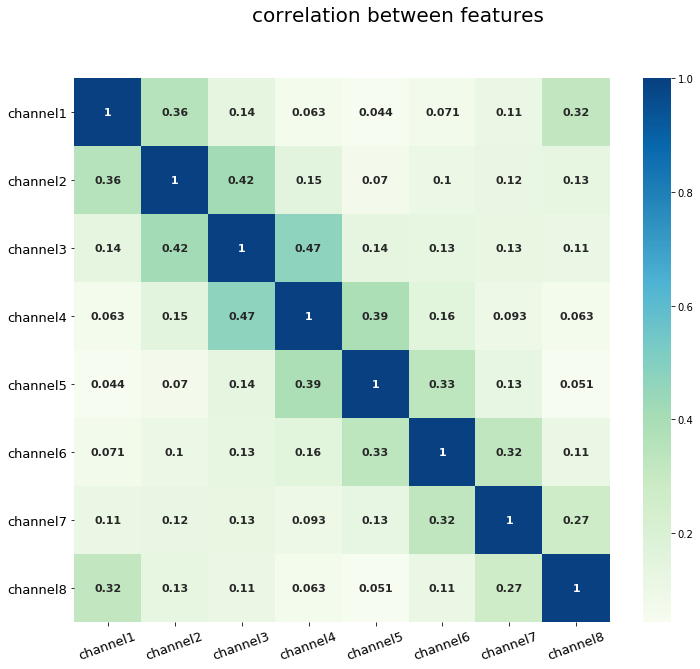

In [20]:
cor = normalized_data.iloc [0: , 2:]


# calculate the correlation matrix
corr = cor.corr()
corr.to_csv('correlation.csv')

# plot the heatmap
plt.figure(figsize=(12, 10))
plt.suptitle('correlation between features', fontsize=20)
plt.autoscale()
ax = sn.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, annot_kws={"fontsize":11, "weight": "bold"}, cmap="GnBu")

plt.xticks(rotation=20, fontsize=13)
plt.yticks(rotation=0, fontsize=13)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

# for tick in ax.get_xticklabels():
#     tick.set_rotation(90)


plt.savefig('corr_plot.png')
plt.show()